### Record linkage - exploration and selection of features

In [1]:
import pandas as pd
import numpy as np
import recordlinkage as rl
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Each observation of the data frame 'comp_scores' represents a pair of records (one death and one birth) and the columns provide the similarity scores calculated after comparing the records on infant's name, mother's name, father's name, infant's sex, county of residence, and date of birth month, day, and year. A 'match' column indicates whether the records in each pair represent the same individual i.e. are "matched" or whether they represent different individuals i.e. are "not matched".

Examining the similarity scores for pairs of records by match status can reveal which features are most likely to distinguish the two groups and so, are likely to be useful in a supervised classification model.

The bar graphs below indicate that all features other than the year of birth have very different similarity scores for matching vs. non-matching records and indicate their value to a model in distinguishing between the two classes.

In [3]:
comp_scores = pd.read_csv(r'###\data\clean\infdth_comparison_1617_labelled.csv', 
                          index_col=[0,1])
comp_scores.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 454323 entries, (12016000010, 52016000522) to (12017087228, 52017091113)
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   cmp_inf_lname     454323 non-null  int64
 1   cmp_inf_phonetic  454323 non-null  int64
 2   cmp_mom_lname     454323 non-null  int64
 3   cmp_mom_phonetic  454323 non-null  int64
 4   cmp_dad_lname     454323 non-null  int64
 5   cmp_dad_phonetic  454323 non-null  int64
 6   cmp_dobm          454323 non-null  int64
 7   cmp_doby          454323 non-null  int64
 8   cmp_dobd          454323 non-null  int64
 9   cmp_sex           454323 non-null  int64
 10  cmp_rescounty     454323 non-null  int64
 11  match             454323 non-null  int64
dtypes: int64(12)
memory usage: 43.3 MB


In [4]:
# recode 'match' variable from 0 and 1 to 'not matched' and 'matched' to make plots more understandable
comp_scores.match = comp_scores.match.replace(to_replace = {0: "Not matched", 1: "Matched"}).astype('category')

comp_scores.match.dtypes

CategoricalDtype(categories=['Matched', 'Not matched'], ordered=False)

In [5]:
# define function to create bar plots

def make_plot(title, yvar):
    mypal = sns.color_palette("coolwarm",2)
    font = {'weight': 'normal',
            'size': 14}
    ax = sns.catplot(data=comp_scores,
                     x="match", 
                     y=yvar, 
                     kind = "bar", 
                     height=5,
                     aspect=1,
                     palette=mypal)
    ax.set(xlabel = "Class", ylabel="Similarity score")
    plt.title(title, pad=30, fontdict=font)
    plt.show()

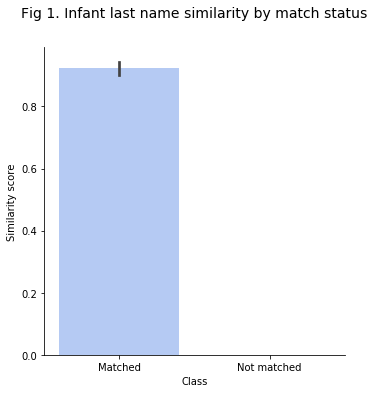

In [6]:
# infant last name by match status

make_plot('Fig 1. Infant last name similarity by match status',"cmp_inf_lname" )

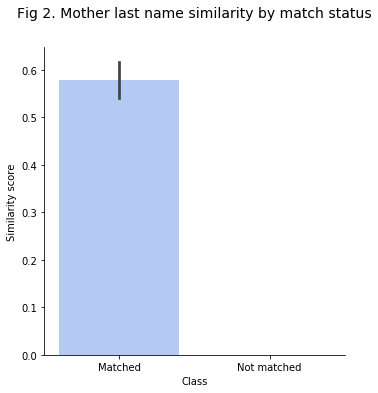

In [7]:
# mother last name similarity by match status

make_plot('Fig 2. Mother last name similarity by match status','cmp_mom_lname' )

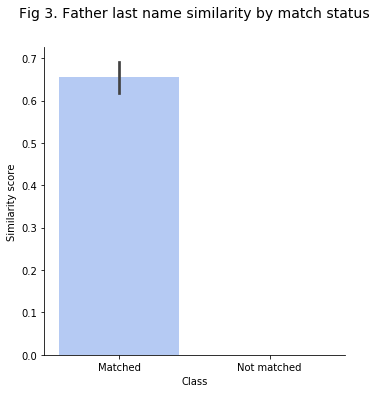

In [8]:
# father last name similarity by match status

make_plot('Fig 3. Father last name similarity by match status','cmp_dad_lname')


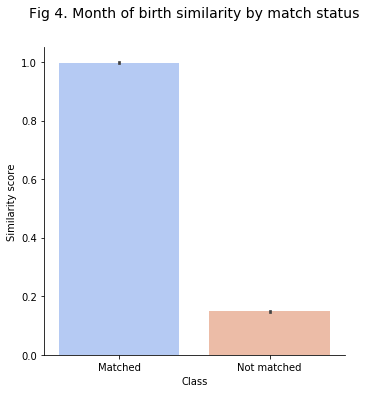

In [9]:
# infant date of birth month similarity by match status

make_plot('Fig 4. Month of birth similarity by match status','cmp_dobm')


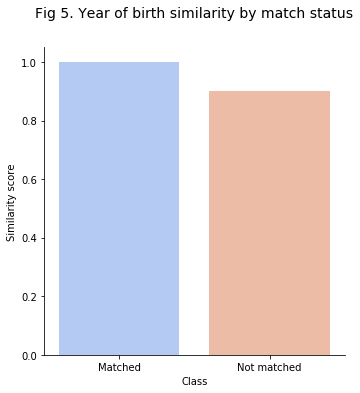

In [10]:
# infant date of birth year similarity by match status

make_plot('Fig 5. Year of birth similarity by match status','cmp_doby')


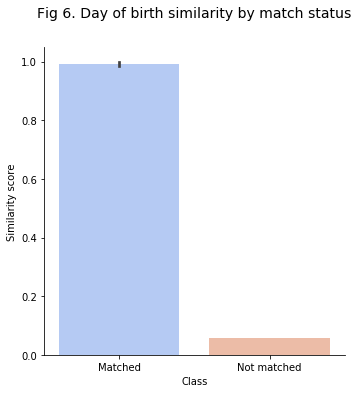

In [11]:
# infant date of birth day similarity by match status

make_plot('Fig 6. Day of birth similarity by match status','cmp_dobd')


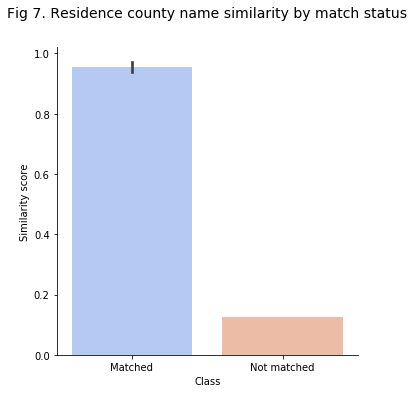

In [12]:
# residence county similarity by match status

make_plot('Fig 7. Residence county name similarity by match status','cmp_rescounty')


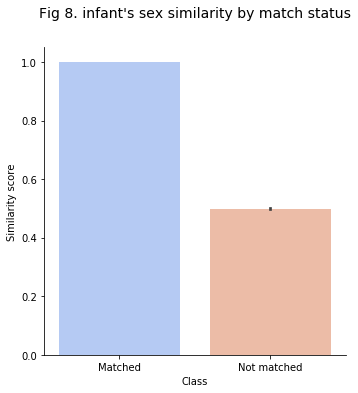

In [13]:
# sex similarity by match status

make_plot("Fig 8. infant's sex similarity by match status",'cmp_sex')


Potting a correlation heatmap of all similarity scores in the data frame reveals features that are highly correlated with each other.  For logistic regression classifiers, inclusion of highly correlated features may cause problems due to multicollinearity. Both features will have the same effect on the dependent variable (match status) so this step will help in identifying features that I should consider excluding from the logistic regression model.

In [14]:
features = comp_scores.loc[:, comp_scores.columns !='match']
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 454323 entries, (12016000010, 52016000522) to (12017087228, 52017091113)
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   cmp_inf_lname     454323 non-null  int64
 1   cmp_inf_phonetic  454323 non-null  int64
 2   cmp_mom_lname     454323 non-null  int64
 3   cmp_mom_phonetic  454323 non-null  int64
 4   cmp_dad_lname     454323 non-null  int64
 5   cmp_dad_phonetic  454323 non-null  int64
 6   cmp_dobm          454323 non-null  int64
 7   cmp_doby          454323 non-null  int64
 8   cmp_dobd          454323 non-null  int64
 9   cmp_sex           454323 non-null  int64
 10  cmp_rescounty     454323 non-null  int64
dtypes: int64(11)
memory usage: 39.9 MB


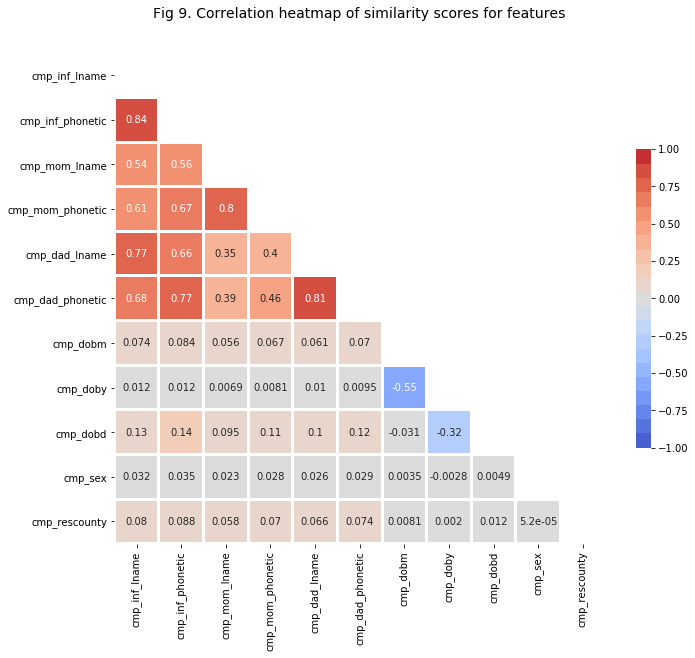

In [15]:
corrmat = features.corr()

plt.figure(figsize=(11, 11))

mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
font = {'weight': 'normal',
        'size': 14} 

sns.heatmap(corrmat, 
            vmin = -1.0, vmax=1.0, center = 0, 
            annot = True, fmt ='.2g', annot_kws={'size':10},
            cbar_kws={"shrink": .50},
            square=True,
            cmap = sns.color_palette("coolwarm",21),
            linewidths=2, linecolor='white',
            mask = mask)
plt.title('Fig 9. Correlation heatmap of similarity scores for features', pad = 35, fontdict=font)
plt.show()

Feature pairs with high correlation coefficients (over 0.75) revealed by the corrleation heatmap include:

- infant name phonetically encoded and infant's last name,
- mother's name phonetically encoded and mother's last name,
- father's name phonetically encoded and father's last name,
- father's last name and infant's last name,
- father's name phonetically encoded and infant's name phonetically encoded.

For each of these feature pairs I will drop one feature and keep the other in the logistic regression model.  Random forest classifiers are not affected by multicollinearity so this analysis is more pertinent to the logistic regression classifier.